In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

print("Import Sucess !!")

Import Sucess !!


Number of images in the train set :  63
Number of images in the test set ;  63
Number of images in prediction set :  63


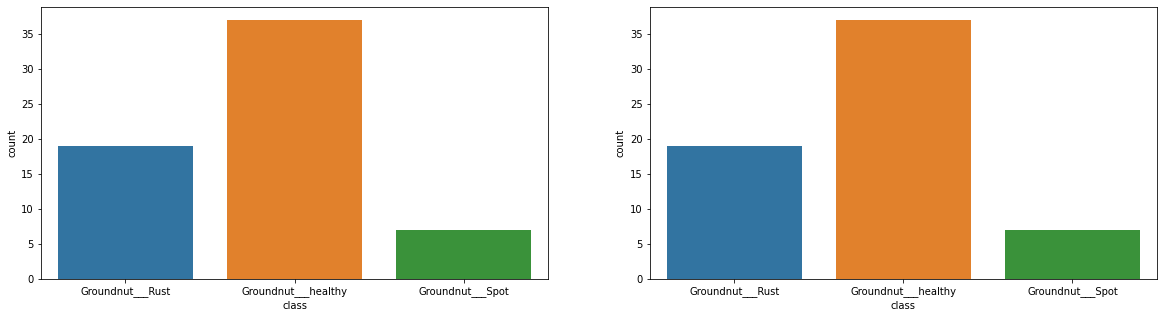

In [3]:
root_path = '/content/drive/MyDrive/Colab Notebooks/Peanut Classifier/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/drive/MyDrive/Colab Notebooks/Peanut Classifier/datasets/train/' #one more seg_train folder within
seg_test_folders = '/content/drive/MyDrive/Colab Notebooks/Peanut Classifier/datasets/test/'
seg_pred_folders = '/content/drive/MyDrive/Colab Notebooks/Peanut Classifier/datasets/pred/'
quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    
    
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))

for folder in os.listdir(seg_test_folders):
    
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [4]:
 def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

In [5]:
train_datagen = ImageDataGenerator( rescale = 1.0/255.,shear_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(seg_train_folders,
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    target_size=(250, 250))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(seg_test_folders, shuffle=True, batch_size=1, class_mode='categorical', target_size=(250, 250))

Found 63 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [6]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'Groundnut___Rust': 0, 'Groundnut___Spot': 1, 'Groundnut___healthy': 2}
{0: 'Groundnut___Rust', 1: 'Groundnut___Spot', 2: 'Groundnut___healthy'}


In [7]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_train_folders)):
        if folder != ".DS_Store":
            image_ids = os.listdir(os.path.join(seg_train_folders,folder))
            for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
                if image_ids != ".DS_Store":
                    display = plt.imread(os.path.join(seg_train_folders,folder,image_ids[j]))
                    plt.axis('off')
                    ax1[axs].imshow(display)
                    title = 'True:'+folder
                    if(predict_using_model):
                        predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                        title = title+'\nPredict :'+predicted_classname
                    ax1[axs].set_title(title)
                    axs=axs+1

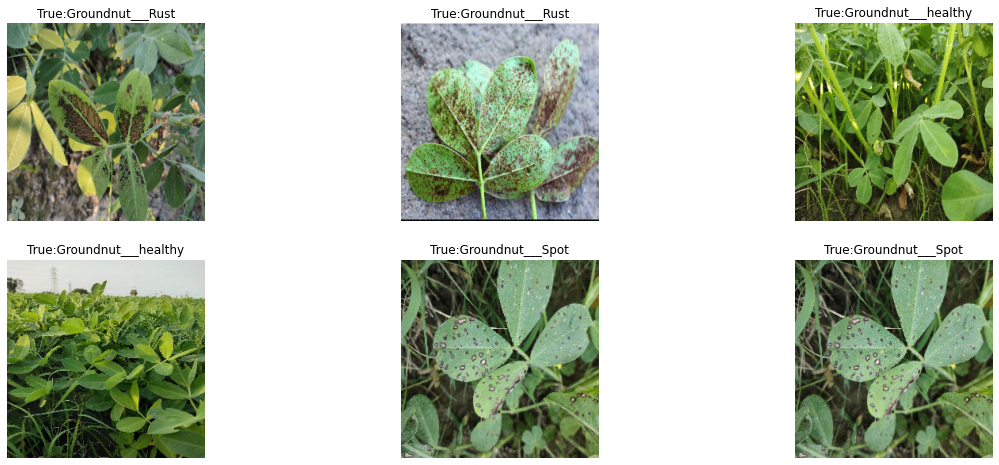

In [8]:
show_few_images(2)

In [9]:
tf.keras.backend.clear_session()

# epoch config
benchmark_epoch = 60
vgg_epoch = 60
resnet_epoch = 60
inception_epoch = 60

In [10]:
#CNN base Model
benchmark_model = Sequential()

benchmark_model.add(Conv2D(128, kernel_size=7, activation='relu', input_shape=(250,250,3)))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(Flatten())
benchmark_model.add(Dense(128,activation='relu'))
benchmark_model.add(Dense(3,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 244, 244, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 121, 121, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      204864    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 57, 57, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 207936)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [11]:
# plot_model(benchmark_model, to_file='model.png',show_shapes=True, show_layer_names=True)
# from IPython.display import FileLink
# FileLink(r'./resnet50_-saved-model-08-acc-0.75.hdf5')

Epoch 1/60
2/2 [==============================] - ETA: 0s - loss: 12.7945 - acc: 0.3492
Epoch 1: val_acc improved from -inf to 0.30159, saving model to bench_mark_-model-01-0.30.hdf5
2/2 [==============================] - 68s 33s/step - loss: 12.7945 - acc: 0.3492 - val_loss: 2.4859 - val_acc: 0.3016 - lr: 0.0010
Epoch 2/60
2/2 [==============================] - ETA: 0s - loss: 1.8018 - acc: 0.4603 
Epoch 2: val_acc improved from 0.30159 to 0.58730, saving model to bench_mark_-model-02-0.59.hdf5
2/2 [==============================] - 56s 34s/step - loss: 1.8018 - acc: 0.4603 - val_loss: 1.8279 - val_acc: 0.5873 - lr: 0.0010
Epoch 3/60
2/2 [==============================] - ETA: 0s - loss: 1.6161 - acc: 0.5873 
Epoch 3: val_acc did not improve from 0.58730
2/2 [==============================] - 55s 32s/step - loss: 1.6161 - acc: 0.5873 - val_loss: 1.0657 - val_acc: 0.3333 - lr: 0.0010
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 1.0801 - acc: 0.3016 
Epoch 4: val_ac

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


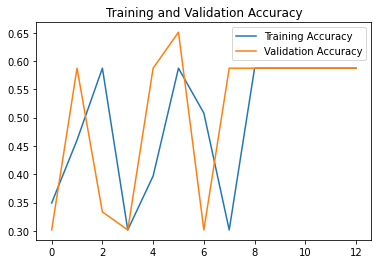

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


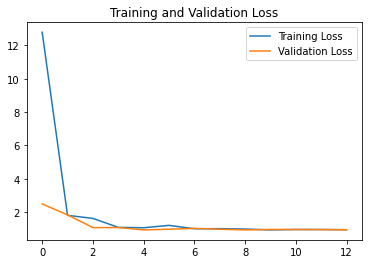

<Figure size 432x288 with 0 Axes>

In [12]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=benchmark_epoch, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

benchmark_model.save(filepath)
do_history_stuff(history, 'benchmark_model')


Epoch 1/60
2/2 [==============================] - ETA: 0s - loss: 1.0419 - acc: 0.5397 
Epoch 1: val_acc improved from -inf to 0.61905, saving model to vgg_16_-saved-model-01-acc-0.62.hdf5
2/2 [==============================] - 82s 60s/step - loss: 1.0419 - acc: 0.5397 - val_loss: 0.9166 - val_acc: 0.6190
Epoch 2/60
2/2 [==============================] - ETA: 0s - loss: 0.9063 - acc: 0.6349 
Epoch 2: val_acc improved from 0.61905 to 0.65079, saving model to vgg_16_-saved-model-02-acc-0.65.hdf5
2/2 [==============================] - 80s 60s/step - loss: 0.9063 - acc: 0.6349 - val_loss: 0.8929 - val_acc: 0.6508
Epoch 3/60
2/2 [==============================] - ETA: 0s - loss: 0.8795 - acc: 0.6667 
Epoch 3: val_acc improved from 0.65079 to 0.69841, saving model to vgg_16_-saved-model-03-acc-0.70.hdf5
2/2 [==============================] - 80s 59s/step - loss: 0.8795 - acc: 0.6667 - val_loss: 0.8754 - val_acc: 0.6984
Epoch 4/60
2/2 [==============================] - ETA: 0s - loss: 0.8719 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


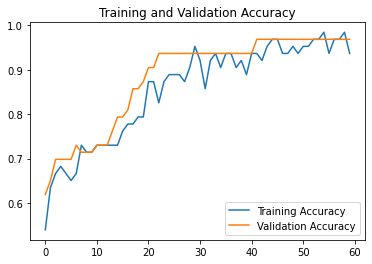

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


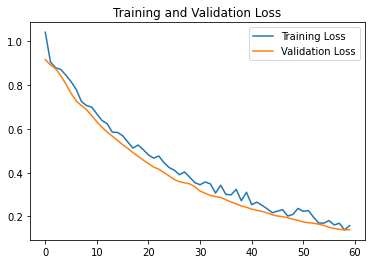

<Figure size 432x288 with 0 Axes>

In [13]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(250,250,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(3, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

# VGG16
number_of_epochs = vgg_epoch
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

do_history_stuff(vgg16_history, 'vgg16_model')

Name                    Type                  Shape
0                     input_17              InputLayer  [(None, 250, 250, 3)]
1                 block1_conv1                  Conv2D   (None, 250, 250, 64)
2                 block1_conv2                  Conv2D   (None, 250, 250, 64)
3                  block1_pool            MaxPooling2D   (None, 125, 125, 64)
4                 block2_conv1                  Conv2D  (None, 125, 125, 128)
5                 block2_conv2                  Conv2D  (None, 125, 125, 128)
6                  block2_pool            MaxPooling2D    (None, 62, 62, 128)
7                 block3_conv1                  Conv2D    (None, 62, 62, 256)
8                 block3_conv2                  Conv2D    (None, 62, 62, 256)
9                 block3_conv3                  Conv2D    (None, 62, 62, 256)
10                 block3_pool            MaxPooling2D    (None, 31, 31, 256)
11                block4_conv1                  Conv2D    (None, 31, 31, 512)
12                block4_conv2                  Conv2D    (None, 31, 31, 512)
13                block4_conv3                  Conv2D    (None, 31, 31, 512)
14                 block4_pool            MaxPooling2D    (None, 15, 15, 512)
15                block5_conv1                  Conv2D    (None, 15, 15, 512)
16                block5_conv2                  Conv2D    (None, 15, 15, 512)
17                block5_conv3                  Conv2D    (None, 15, 15, 512)
18                 block5_pool            MaxPooling2D      (None, 7, 7, 512)
19  global_average_pooling2d_1  GlobalAveragePooling2D            (None, 512)

In [58]:
ResNet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250,250,3), classes=3)
table=pd.DataFrame(columns=["Name","Type","Shape"])
for layer in ResNet50_model.layers:
    table = table.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape}, ignore_index=True)
table.head()
for layers in ResNet50_model.layers:
    layers.trainable=True

opt = SGD(lr=0.01,momentum=0.7)
resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(3,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs=ResNet50_model.input, outputs=resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])

number_of_epochs = resnet_epoch
resnet_filepath = 'resnet50'+'-saved-model-{epoch:02d}-val_acc-{val_acc:.2f}.hdf5'
resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
callbacklist = [resnet_checkpoint,resnet_early_stopping,reduce_lr]
resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)

do_history_stuff(resnet50_history, 'resnet50_model')



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/60


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/60
2/2 [==============================] - 33s 20s/step - loss: 1.7009 - accuracy: 0.3175 - val_loss: 1.2738 - val_accuracy: 0.3968
Epoch 2/60
2/2 [==============================] - 26s 18s/step - loss: 1.3083 - accuracy: 0.3968 - val_loss: 1.0129 - val_accuracy: 0.4762
Epoch 3/60
2/2 [==============================] - 25s 18s/step - loss: 1.1652 - accuracy: 0.5079 - val_loss: 0.8108 - val_accuracy: 0.6190
Epoch 4/60
2/2 [==============================] - 25s 18s/step - loss: 0.9102 - accuracy: 0.5714 - val_loss: 0.7038 - val_accuracy: 0.6349
Epoch 5/60
2/2 [==============================] - 25s 18s/step - loss: 0.6995 - accuracy: 0.7619 - val_loss: 0.6285 - val_accuracy: 0.6825
Epoch 6/60
2/2 [==============================] - 26s 18s/step - loss: 0.7008 - accuracy: 0.6825 - val_loss: 0.5403 - val_accuracy: 0.7302
Epoch 7/60
2/2 [==============================] - 25s 18s/step - loss: 0.5889 - accuracy: 0.8571 - val_loss: 0.4534 - val_accuracy: 0.7619
Epoch 8/60
2/2 [===========

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


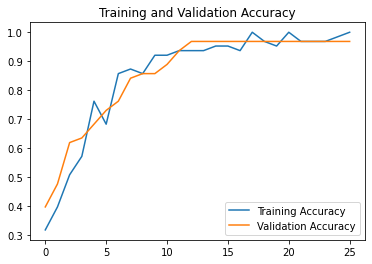

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


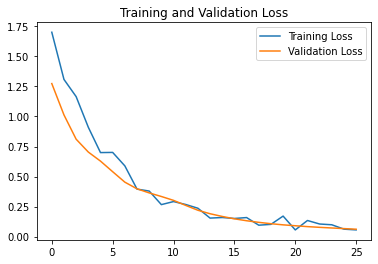

<Figure size 432x288 with 0 Axes>

In [15]:
# this could also be the output a different Keras model or layer

InceptionV3_model = InceptionV3(input_shape=(250,250,3),weights='imagenet', include_top=False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True
InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(3, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs=InceptionV3_model.input,outputs=InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

number_of_epochs = inception_epoch
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'
inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

do_history_stuff(inceptionv3_history, 'inceptionv3_model', True)  

### Combining the best models of VGG16, Resnet50 & InceptionV3

In [16]:
#vgg_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/vgg_16_-saved-model-15-acc-0.88.hdf5')
#resnet_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/resnet50-saved-model-11-val_acc-0.92.hdf5')
#inception_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/inceptionv3_-saved-model-03-loss-0.22.hdf5')
#benchmark_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/bench_mark_-model-18-0.79.hdf5')
vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 

In [17]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
for folder in os.listdir(seg_test_folders):
    if folder != ".DS_Store":
        test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))

        for image_id in test_image_ids[:int(len(test_image_ids))]:
            if image_id != ".DS_Store":
                path = os.path.join(seg_test_folders,folder,image_id)
                print(image_id)
                true_value.append(validation_generator.class_indices[folder])
                print(validation_generator.class_indices[folder])
                
                img = cv2.resize(cv2.imread(path),(250,250))


            img_normalized = img/255
            #vgg
            vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
            vgg_pred.append(vgg16_image_prediction)

            #resnet50
            resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
            resnet_pred.append(resnet_50_image_prediction)

            #Inception
            inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
            inception_pred.append(inception_image_prediction)

            #benchmark
            benchmark_model_prediction = np.argmax(benchmark_model.predict(np.array([img_normalized])))
            benchmark_model_pred.append(benchmark_model_prediction)
            print(benchmark_model_prediction)
            #giving vgg16 high priority if they all predict something different
            image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
            combined_model_pred.append(image_prediction)
            print("---")

image   0.jpg
0
2
---
image   3.jpg
0
2
---
image   6.jpg
0
2
---
image   2.jpg
0
2
---
image   1.jpg
0
2
---
image   4.jpg
0
2
---
image   5.jpg
0
2
---
image  13.jpg
0
2
---
image  14.jpg
0
2
---
image  10.jpg
0
2
---
image   8.jpg
0
2
---
image  11.jpg
0
2
---
image   7.jpg
0
2
---
image  12.jpg
0
2
---
image   9.jpg
0
2
---
image  15.jpg
0
2
---
image  18.jpg
0
2
---
image  17.jpg
0
2
---
image  16.jpg
0
2
---
image   0.jpg
2
2
---
image   4.jpg
2
2
---
image   1.jpg
2
2
---
image   3.jpg
2
2
---
image   5.jpg
2
2
---
image   2.jpg
2
2
---
image  12.jpg
2
2
---
image   8.jpg
2
2
---
image   7.jpg
2
2
---
image   6.jpg
2
2
---
image  11.jpg
2
2
---
image  14.jpg
2
2
---
image   9.jpg
2
2
---
image  10.jpg
2
2
---
image  15.jpg
2
2
---
image  13.jpg
2
2
---
image  18.jpg
2
2
---
image  22.jpg
2
2
---
image  16.jpg
2
2
---
image  19.jpg
2
2
---
image  20.jpg
2
2
---
image  21.jpg
2
2
---
image  17.jpg
2
2
---
image  23.jpg
2
2
---
image  27.jpg
2
2
---
image  29.jpg
2
2
---
image  30.

In [18]:
print(len(true_value))
print(len(benchmark_model_pred))

63
63


In [19]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

Model Accuracy 0.5873015873015873
                     precision    recall  f1-score   support

   Groundnut___Rust       0.00      0.00      0.00        19
   Groundnut___Spot       0.00      0.00      0.00         7
Groundnut___healthy       0.59      1.00      0.74        37

           accuracy                           0.59        63
          macro avg       0.20      0.33      0.25        63
       weighted avg       0.34      0.59      0.43        63



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


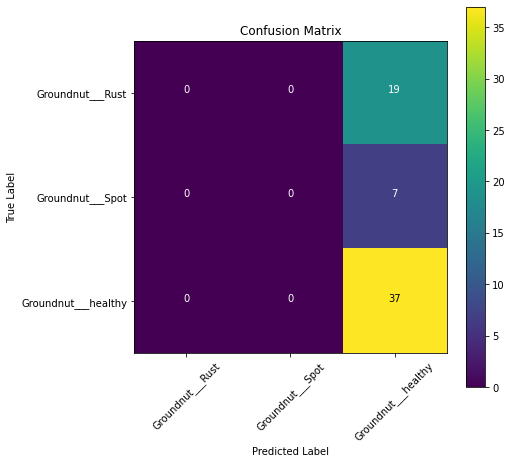

In [20]:
#benchmark model
clf_report(true_value, benchmark_model_pred)

Model Accuracy 0.9365079365079365
                     precision    recall  f1-score   support

   Groundnut___Rust       0.89      0.89      0.89        19
   Groundnut___Spot       1.00      0.71      0.83         7
Groundnut___healthy       0.95      1.00      0.97        37

           accuracy                           0.94        63
          macro avg       0.95      0.87      0.90        63
       weighted avg       0.94      0.94      0.93        63



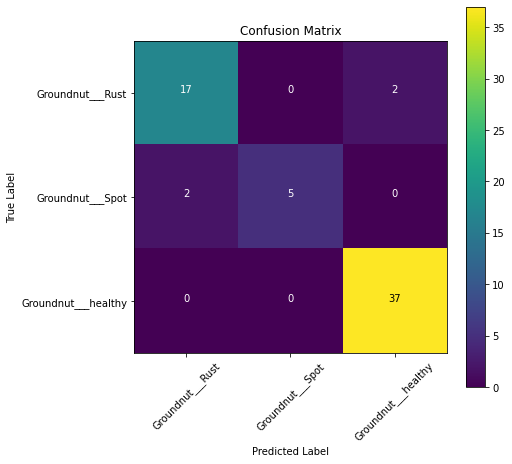

In [21]:
#combined vote
combined_model_pred = [ c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)

Model Accuracy 0.8888888888888888
                     precision    recall  f1-score   support

   Groundnut___Rust       0.73      1.00      0.84        19
   Groundnut___Spot       1.00      0.71      0.83         7
Groundnut___healthy       1.00      0.86      0.93        37

           accuracy                           0.89        63
          macro avg       0.91      0.86      0.87        63
       weighted avg       0.92      0.89      0.89        63



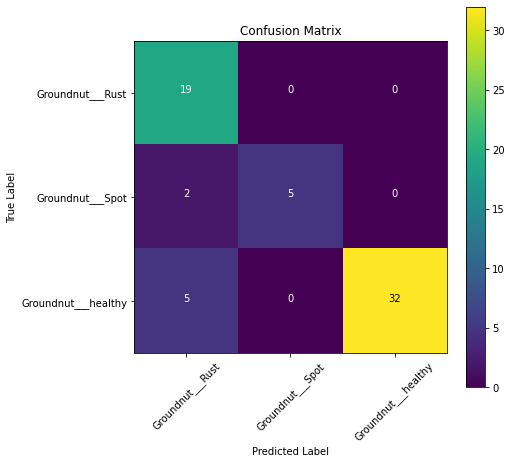

In [22]:
# VGG model classification report
clf_report(true_value, vgg_pred)

Model Accuracy 0.5873015873015873
                     precision    recall  f1-score   support

   Groundnut___Rust       0.00      0.00      0.00        19
   Groundnut___Spot       0.00      0.00      0.00         7
Groundnut___healthy       0.59      1.00      0.74        37

           accuracy                           0.59        63
          macro avg       0.20      0.33      0.25        63
       weighted avg       0.34      0.59      0.43        63



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


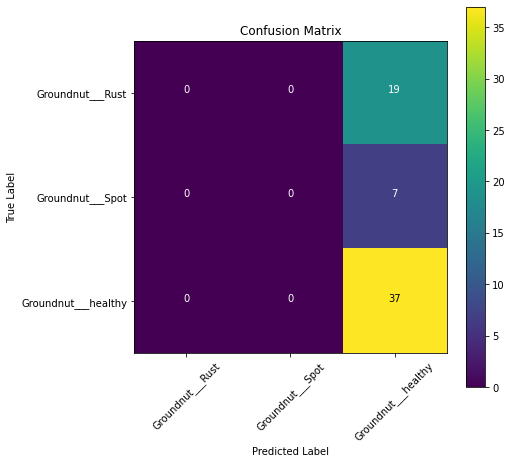

In [23]:
# Resnet50 model classification report
clf_report(true_value, resnet_pred)

Model Accuracy 0.9682539682539683
                     precision    recall  f1-score   support

   Groundnut___Rust       1.00      0.89      0.94        19
   Groundnut___Spot       1.00      1.00      1.00         7
Groundnut___healthy       0.95      1.00      0.97        37

           accuracy                           0.97        63
          macro avg       0.98      0.96      0.97        63
       weighted avg       0.97      0.97      0.97        63



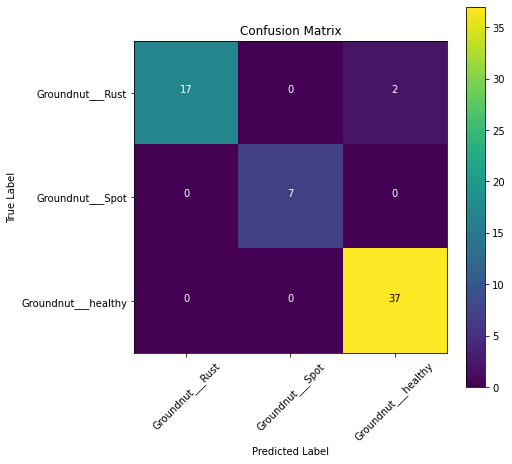

In [24]:
# Inception model classification report
clf_report(true_value, inception_pred)

In [47]:
def show_few_images(number_of_examples=2, predict_using_model=None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(seg_train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(seg_test_folders)):
        image_ids = os.listdir(os.path.join(seg_test_folders,folder))
        

        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(seg_test_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+ folder
            ax1[axs].set_title(title)
            axs=axs+1

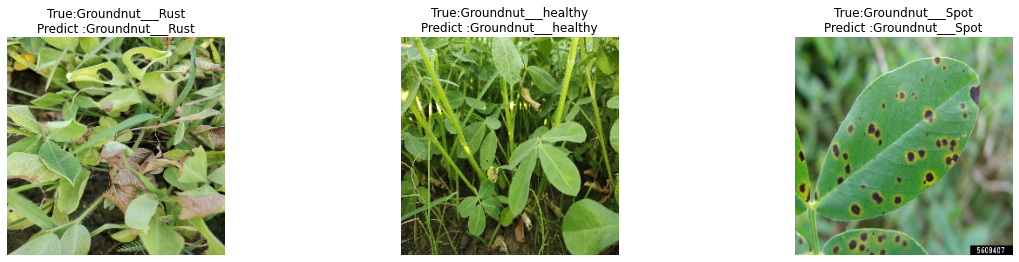

In [53]:
show_few_images(1,benchmark_model_pred)

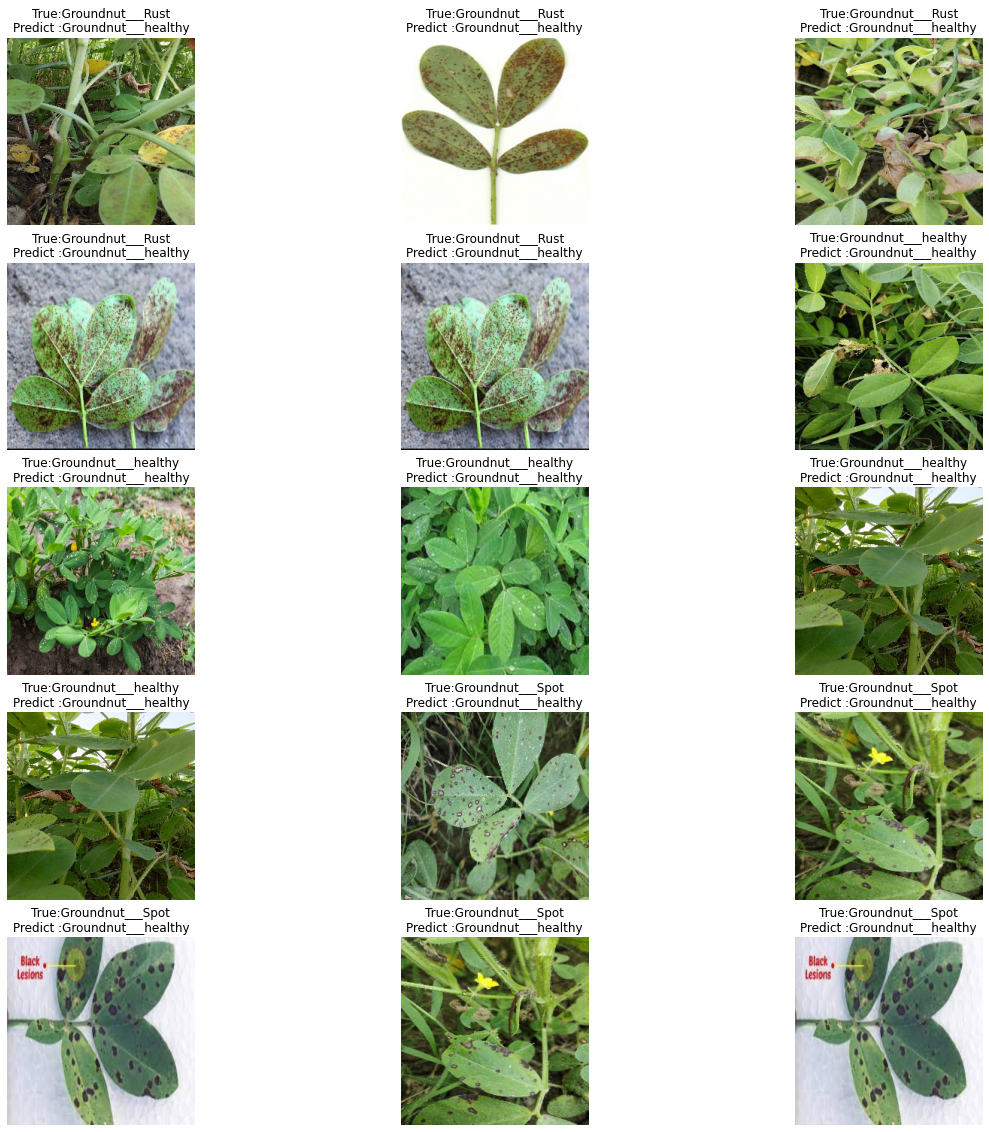

In [42]:
show_few_images(5,vgg_pred)

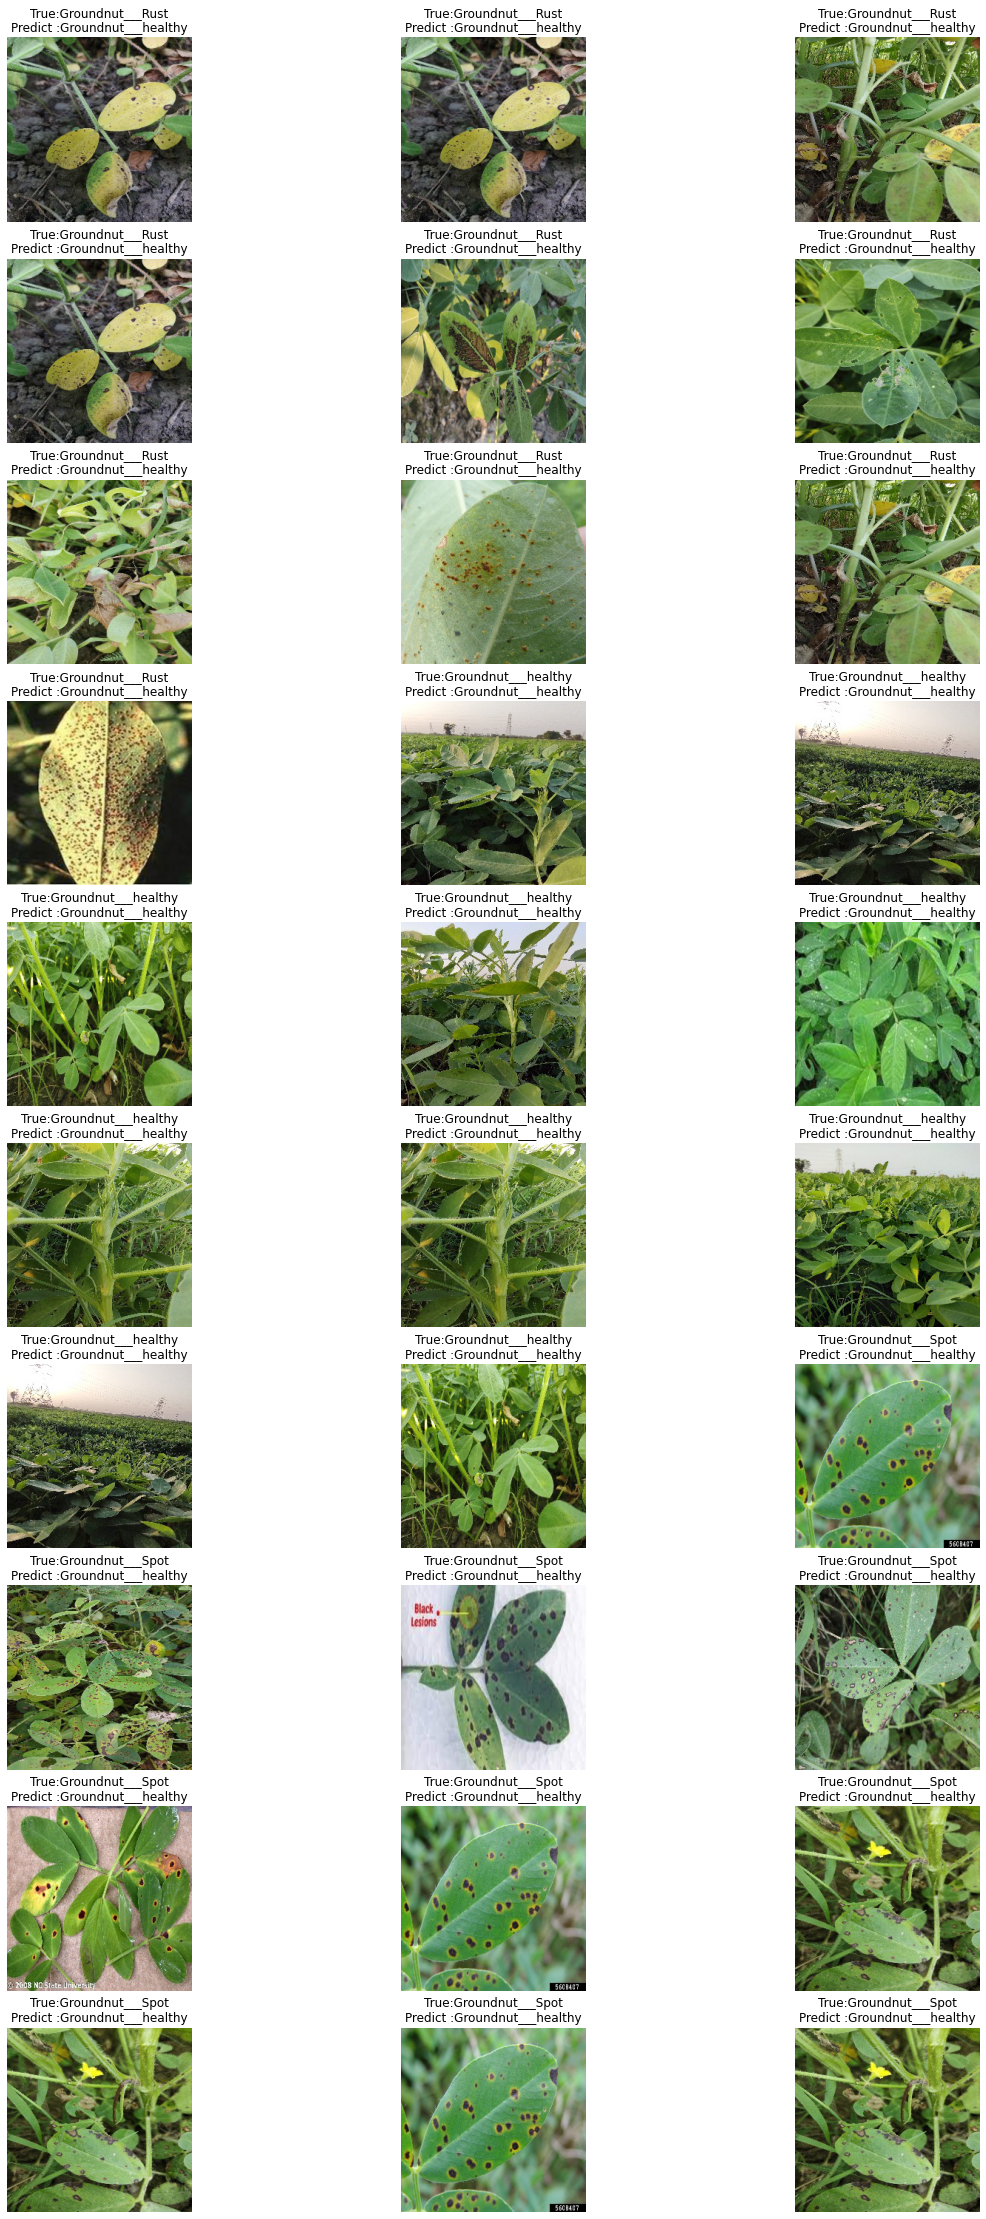

In [37]:
show_few_images(10,resnet_pred)

['image   0.jpg', 'image   3.jpg', 'image   5.jpg', 'image   2.jpg', 'image   4.jpg', 'image   1.jpg', 'image   6.jpg', 'image   7.jpg', 'image   9.jpg', 'image  13.jpg', 'image   8.jpg', 'image  11.jpg', 'image  10.jpg', 'image  14.jpg', 'image  12.jpg', 'image  16.jpg', 'image  18.jpg', 'image  17.jpg', 'image  15.jpg']
['image   0.jpg', 'image   1.jpg', 'image   2.jpg', 'image   4.jpg', 'image   3.jpg', 'image   5.jpg', 'image  12.jpg', 'image  14.jpg', 'image   9.jpg', 'image  15.jpg', 'image   6.jpg', 'image  10.jpg', 'image   7.jpg', 'image  11.jpg', 'image   8.jpg', 'image  13.jpg', 'image  20.jpg', 'image  21.jpg', 'image  19.jpg', 'image  17.jpg', 'image  16.jpg', 'image  22.jpg', 'image  23.jpg', 'image  18.jpg', 'image  25.jpg', 'image  27.jpg', 'image  26.jpg', 'image  24.jpg', 'image  28.jpg', 'image  29.jpg', 'image  30.jpg', 'image  36.jpg', 'image  32.jpg', 'image  33.jpg', 'image  35.jpg', 'image  31.jpg', 'image  34.jpg']
['image   3.jpg', 'image   6.jpg', 'image   2.

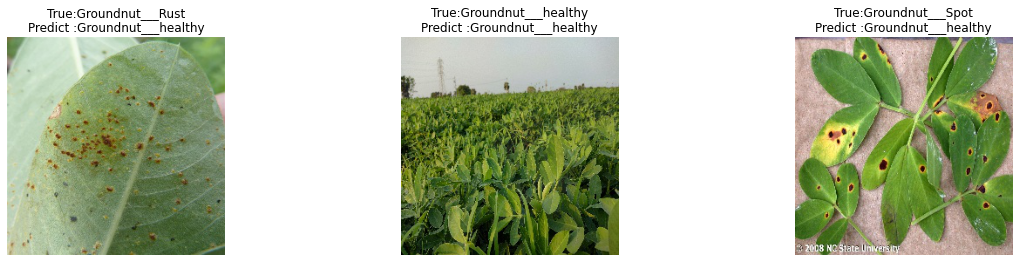

In [29]:
show_few_images(1,inception_pred)

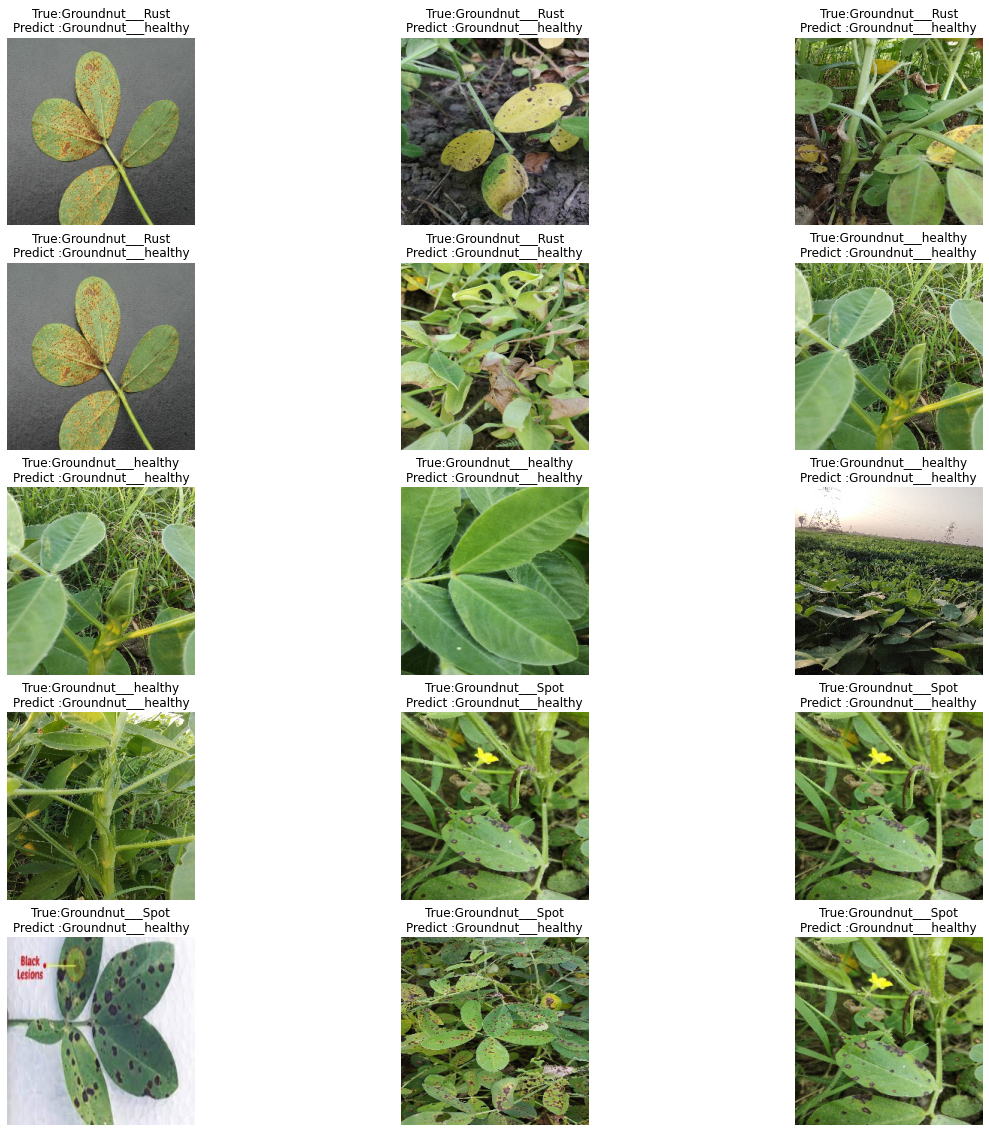

In [43]:
show_few_images(5,combined_model_pred)